In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten, GlobalAveragePooling2D

In [2]:
# constants
DATA_DIR = r'"C:\Users\Karthick\Desktop\Diabetic retinopathy Detection"'
BATCH_SIZE = 32
EPOCHS = 100
SEED = 420
IMG_SIZE = (224,224)
INPUT_SHAPE = (224, 224, 3)
BASE_LR = 0.001
NUM_CLASSES = 5

In [3]:
# importing data
train_df = pd.read_csv(r"C:\Users\Karthick\Desktop\Diabetic retinopathy Detection\train.csv")
test_df = pd.read_csv(r"C:\Users\Karthick\Desktop\Diabetic retinopathy Detection\test.csv")

In [4]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


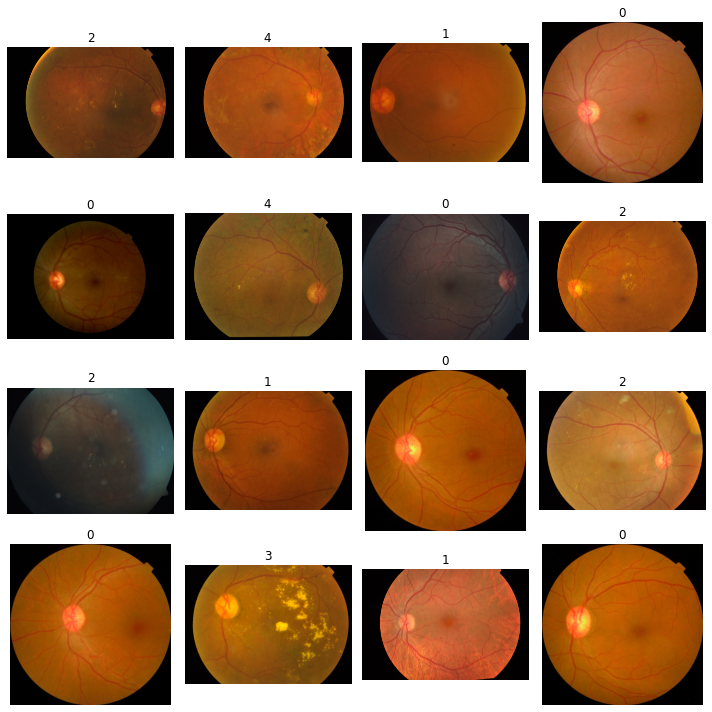

In [5]:
# to display images
def display_image(df, rows, columns):
    fig=plt.figure(figsize=(10, 10))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'C:/Users/Karthick/Desktop/Diabetic retinopathy Detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.axis('off')
        plt.imshow(img)
    
    plt.tight_layout()
    plt.show()
    
def display_single_image(img):
    fig=plt.figure(figsize=(10, 10))
    plt.title('Sample Img')
    plt.imshow(img)
    plt.show()
    
display_image(train_df, 4, 4)

In [6]:
def load_ben_color(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMG_SIZE)
    return image

def preprocess_image(image_path):
    img = load_ben_color(image_path)
    return img

x_train = np.empty((train_df.shape[0], 224, 224, 3), dtype=np.uint8)
for i, image_id in enumerate((train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(f"C:/Users/Karthick/Desktop/Diabetic retinopathy Detection/train_images/{image_id}.png")

x_test = np.empty((test_df.shape[0], 224, 224, 3), dtype=np.uint8)
for i, image_id in enumerate((test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(f'C:/Users/Karthick/Desktop/Diabetic retinopathy Detection/test_images/{image_id}.png')

# get one-hot encoded diagnosis
y_train = pd.get_dummies(train_df['diagnosis']).values


In [7]:
# to balance dataset using SMOTE
#!pip install imblearn
#!conda install -c glemaitre imbalanced-learn
from imblearn.over_sampling import SMOTE
x_resampled, y_resampled = SMOTE(random_state=SEED).fit_resample(x_train.reshape(x_train.shape[0], -1), train_df['diagnosis'].ravel())

x_train = x_resampled.reshape(x_resampled.shape[0], 224, 224, 3)
y_train = pd.get_dummies(y_resampled).values

print("x_train.shape=",x_train.shape)
print("y_train.shape=",y_train.shape)

x_train.shape= (9025, 224, 224, 3)
y_train.shape= (9025, 5)


In [8]:
# splitting data into training and validation data
x_sptrain, x_spval, y_sptrain, y_spval = train_test_split(
    x_train, y_train,
    test_size=0.10, 
    random_state=SEED
)

In [9]:
# importing inceptionv3 from tensorflow
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

In [10]:
m= InceptionV3()
m.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [11]:
from sklearn.metrics import *

import tensorflow.keras.backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0.0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=1)

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*(p*r) / (p+r+K.epsilon())

In [12]:
# using InceptionV3 building a model for training
inceptionv3 = InceptionV3(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
inceptionv3.trainable = False

inputs = tf.keras.Input(shape=INPUT_SHAPE)

x = preprocess_input(inputs)
x = inceptionv3(x, training = False)
x = GlobalAveragePooling2D()(x)

x = Dense(100, activation = 'relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(NUM_CLASSES, activation = 'softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LR),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', mean_pred, precision, recall, f1_score, fbeta_score]
             )
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [13]:
# callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=24, verbose=1)
ckpt_path = './training/model.ckpt'
mc = tf.keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(x_sptrain, y_sptrain, validation_data=(x_spval, y_spval),epochs=100,callbacks = [reduce_lr, early_stopping, mc])

254/254 [==============================] - 266s 1s/step - loss: 1.2436 - categorical_accuracy: 0.4613 - mean_pred: 0.2000 - precision: 0.7061 - recall: 0.2263 - f1_score: 0.3357 - fbeta_score: 0.3357


In [14]:
from pickle import dump

In [15]:
dump(history,open('model.pkl','wb'))

INFO:tensorflow:Assets written to: ram://97e6dbc1-46f2-41f0-a5ed-455f719cad74/assets


INFO:tensorflow:Assets written to: ram://97e6dbc1-46f2-41f0-a5ed-455f719cad74/assets


In [14]:
# function to plot training results
def training_results(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(loss))

    plt.figure(figsize=(8, 8))
    plt.subplot(211)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(212)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [15]:
# plotting training results
training_results(history)

KeyError: 'val_categorical_accuracy'

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.head(EPOCHS)

In [20]:
y_val_pred = model.predict(x_spval)

29/29 [==============================] - 45s 1s/step


In [ ]:
print(y_val_pred)

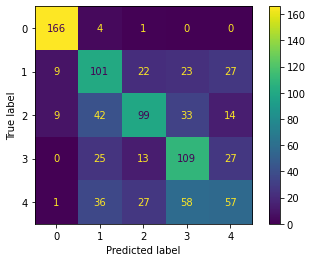

In [22]:
# confusion matrix
cm = confusion_matrix(np.argmax(y_spval, axis=1), np.argmax(y_val_pred, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [23]:
from sklearn import metrics
from sklearn.metrics import classification_report
print("performance measures are: ",classification_report(np.argmax(y_spval, axis=1), np.argmax(y_val_pred, axis=1)))


performance measures are:                precision    recall  f1-score   support

           0       0.90      0.97      0.93       171
           1       0.49      0.55      0.52       182
           2       0.61      0.50      0.55       197
           3       0.49      0.63      0.55       174
           4       0.46      0.32      0.38       179

    accuracy                           0.59       903
   macro avg       0.59      0.59      0.59       903
weighted avg       0.59      0.59      0.58       903

